## Customer Churn Prediction Model

Using the [Telco customer churn data](https://www.kaggle.com/code/mechatronixs/telco-churn-prediction-feature-engineering-eda/data) from kaggle, train a machine learning model to predict customer churn.

In [ ]:
import pandas as pd

: 

In [2]:
# get training data
train = pd.read_csv("./data/training_data.csv")
# drop customer ID: not a feature for training
train.drop("customerID", axis=1, inplace=True)

# getting validation data
val = pd.read_csv("./data/validation_data.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5282 non-null   object 
 1   SeniorCitizen     5282 non-null   int64  
 2   Partner           5282 non-null   object 
 3   Dependents        5282 non-null   object 
 4   tenure            5282 non-null   int64  
 5   PhoneService      5282 non-null   object 
 6   MultipleLines     5282 non-null   object 
 7   InternetService   5282 non-null   object 
 8   OnlineSecurity    5282 non-null   object 
 9   OnlineBackup      5282 non-null   object 
 10  DeviceProtection  5282 non-null   object 
 11  TechSupport       5282 non-null   object 
 12  StreamingTV       5282 non-null   object 
 13  StreamingMovies   5282 non-null   object 
 14  Contract          5282 non-null   object 
 15  PaperlessBilling  5282 non-null   object 
 16  PaymentMethod     5282 non-null   object 


In [8]:
type(train["TotalCharges"][0])

str

#### Converting entries from the column 'TotalCharges' from str to float.

In [9]:
train["TotalCharges"] = pd.to_numeric(train["TotalCharges"], errors="coerce")
val["TotalCharges"] = pd.to_numeric(val["TotalCharges"], errors="coerce")

### Split data and target

In [11]:
train_X = train.drop(["Churn"], axis=1)
train_y = train["Churn"]

val_X = val.drop(["Churn"], axis=1)
val_y = val["Churn"]

In [28]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# XGBoost
from sklearn.ensemble import GradientBoostingClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Support Vector Machine
from sklearn.svm import SVC

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Neural Network
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [14]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

le = LabelEncoder()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [15]:
le.fit(train_y)
train_y = le.transform(train_y)
val_y = le.transform(val_y)

# Logistic Regression

In [19]:
logistic_regression_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(strategy="median")),
        ("classifier", LogisticRegression()),
    ]
)
logistic_regression_pipe.fit(train_X, train_y)  # apply scaling on training data

logistic_regression_pipe.score(
    val_X, val_y
)  # apply scaling on testing data, without leaking training data.

0.8344283837056504

In [20]:
logistic_regression_y_pred = logistic_regression_pipe.predict(val_X)

In [22]:
target_names = le.inverse_transform([0, 1])

              precision    recall  f1-score   support

          No       0.89      0.91      0.90       596
         Yes       0.63      0.58      0.60       165

    accuracy                           0.83       761
   macro avg       0.76      0.74      0.75       761
weighted avg       0.83      0.83      0.83       761



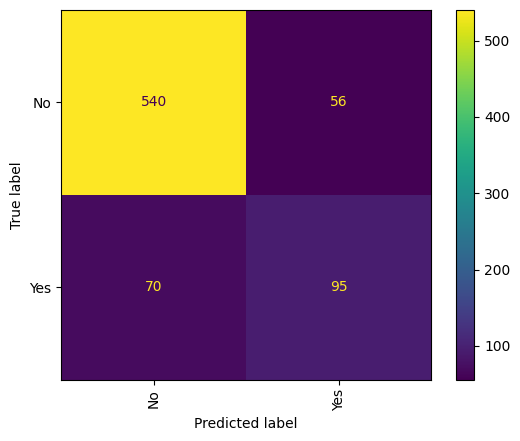

In [26]:
print(
    classification_report(val_y, logistic_regression_y_pred, target_names=target_names)
)
ConfusionMatrixDisplay.from_estimator(
    logistic_regression_pipe,
    val_X,
    val_y,
    display_labels=target_names,
    xticks_rotation="vertical",
)
# plt.tight_layout()
# plt.show()

# XGBoost

In [29]:
XGB_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(strategy="median")),
        ("classifier", GradientBoostingClassifier()),
    ]
)
XGB_pipe.fit(train_X, train_y)  # apply scaling on training data

XGB_pipe.score(
    val_X, val_y
)  # apply scaling on testing data, without leaking training data.

0.8409986859395532

In [30]:
XGB_y_pred = XGB_pipe.predict(val_X)

              precision    recall  f1-score   support

          No       0.88      0.92      0.90       596
         Yes       0.65      0.57      0.61       165

    accuracy                           0.84       761
   macro avg       0.77      0.74      0.75       761
weighted avg       0.83      0.84      0.84       761



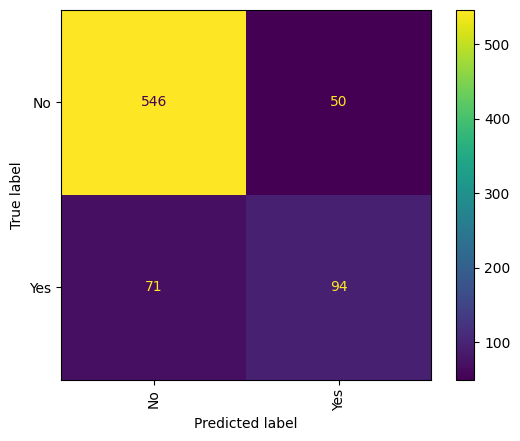

In [31]:
print(classification_report(val_y, XGB_y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    XGB_pipe, val_X, val_y, display_labels=target_names, xticks_rotation="vertical"
)

In [58]:
# pickling mdl
import pickle

mdl_pickler = open("churn_prediction_model.pkl", "wb")
pickle.dump(pipe, mdl_pickler)
mdl_pickler.close()

le_pickler = open("churn_prediction_label_encoders.pkl", "wb")
pickle.dump({"Churn": le}, le_pickler)
le_pickler.close()